In [2]:
import torch
import torch.nn as nn
import torchvision

import numpy as np
from PIL import Image
from tqdm import tqdm
from livelossplot import PlotLosses

from sklearn.metrics import classification_report, f1_score
from sklearn.utils import class_weight

import pprint

%pylab inline
pp = pprint.PrettyPrinter(indent=2)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [3]:
# Change path to root folder of the data provided
path_to_data = '../data/train/'
data_extensions = ['jpg', 'JPG', 'jpeg', 'HEIC', 'jfif']
# a dataset abstraction that figures out classes on it's own based on what folder the images were in
_data = torchvision.datasets.DatasetFolder(
    path_to_data,                                  # root path, it'll get paths to actual images on it's own
    Image.open,                                    # pillow open image function to load data from given path
    data_extensions,                                # list of extensions for images in dataset
    transform = torchvision.transforms.Compose([   # a pipeline of transformations to apply on the read image
        torchvision.transforms.RandomChoice([
            torchvision.transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
            torchvision.transforms.Resize((224, 224))
        ]),
#         torchvision.transforms.RandomApply([
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.RandomVerticalFlip(),
            torchvision.transforms.ColorJitter(
                brightness=0.7,
                contrast=0.7,
                saturation=0.7,
                hue=0.3),
#             torchvision.transforms.RandomRotation(15),
#         ]),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], # the documentation said that alexnet was modelled with
                                 std=[0.229, 0.224, 0.225]),         # images using this normalisation parameters
    ]),
)

test_data = torchvision.datasets.DatasetFolder(
    '../data/validation',
    Image.open,
    data_extensions,
    transform = torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
            torchvision.transforms.Resize((224, 224))
    ])
)

In [4]:
# some unfortunate ugly code to split the data randomly into training and testing
split_at = 0.8
train, test = torch.utils.data.random_split(
    _data,
    [int(split_at*(len(_data))), len(_data) - int(split_at*(len(_data)))]
)
print("Training data: " + str(len(train)) + " images")
print("Testing data: " + str(len(test)) + " images")

Training data: 1114 images
Testing data: 279 images


In [4]:
batch_size = 96
# defining loaders for the train and test datasets
train_batches = torch.utils.data.DataLoader(
    train,                                       # dataset 
    batch_size=batch_size,                       # size of batches to load
    shuffle=True,
    num_workers=8,                               # no of workers
    pin_memory=True                              # Host to GPU copies are much faster when they originate from pinned (page-locked) memory. CPU tensors and storages expose a pin_memory() method, that returns a copy of the object, with data put in a pinned region.
) 

test_batches = torch.utils.data.DataLoader(
    test,                                       # dataset 
    batch_size=batch_size,                      # size of batches to load
    shuffle=True,
    num_workers=8,                               # no of workers
    pin_memory=True                              # Host to GPU copies are much faster when they originate from pinned (page-locked) memory. CPU tensors and storages expose a pin_memory() method, that returns a copy of the object, with data put in a pinned region.
) 

In [5]:
# it'll download alexnet weights on it's own
squeezenet = torchvision.models.squeezenet1_1(
    pretrained=True,
)

c:\python37\lib\site-packages\torchvision\models\squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
c:\python37\lib\site-packages\torchvision\models\squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)


In [6]:
# get list of classes from names of folders inside the path to data
import os
label_names = os.listdir(path_to_data)

# set num of classes, so as to set the output dimensions
squeezenet.num_classes = len(label_names)
print("Classes are - ")
pp.pprint(label_names)
print("\n" + str(len(label_names)) + " classes in total.")

Classes are - 
[ 'FEIT_40W_T8_TUBE_MCRWV_BULB_120V',
  'GE - 48 Inch - F40 - T12 - Bulb Fluorescent',
  'GE_40W_RelaxLED',
  'GE_60W_LED_A19_FROST_5000K_8CT',
  'GE_Appliance_LED_11W_Soft_White',
  'GE_Appliance_LED_40W_Warm_White',
  'GE_Basic_LED_60W_Soft_Light',
  'GE_Basic_LED_90W_Daylight',
  'GE_Classic_LED_65W_Soft_White',
  'GE_Vintage_LED_60W_Warm_Light',
  'OSI_60W_13W_CFL_SOFT_WHITE_6_CT']

11 classes in total.


In [7]:
# create new instances of the same layers, to get rid of the pretrained weights in the classification layers
# we want to learn our own
layers = [
#     nn.BatchNorm2d(512),
    nn.Dropout(0.5),
    nn.Conv2d(512, squeezenet.num_classes, kernel_size=(1, 1), stride=(1, 1)),
#     nn.BatchNorm2d(squeezenet.num_classes),
    nn.ReLU(inplace=True),
#     nn.Dropout(0.5),
    nn.AvgPool2d(kernel_size=13, stride=1, padding=0)
]

# change the classification layers to the untrained ones we just defined
# I am not sure why this syntax works, I found it in a medium article
squeezenet.classifier = nn.Sequential(*layers)
# but it gets the job done
squeezenet.classifier


Sequential(
  (0): Dropout(p=0.5)
  (1): Conv2d(512, 11, kernel_size=(1, 1), stride=(1, 1))
  (2): ReLU(inplace)
  (3): AvgPool2d(kernel_size=13, stride=1, padding=0)
)

In [8]:
def get_class_weights():
    _data = torchvision.datasets.DatasetFolder(
        '../data/train/',                                  # root path, it'll get paths to actual images on it's own
        Image.open,                                    # pillow open image function to load data from given path
        data_extensions,                                # list of extensions for images in dataset
        transform = torchvision.transforms.Compose([   # a pipeline of transformations to apply on the read image
            torchvision.transforms.Resize((224, 224)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], # the documentation said that alexnet was modelled with
                                     std=[0.229, 0.224, 0.225]),         # images using this normalisation parameters
        ]),
    )
    torch.utils.data.DataLoader(
        _data,                                       # dataset 
        batch_size=32,                       # size of batches to load
        num_workers=8,                               # no of workers
        pin_memory=True                              # Host to GPU copies are much faster when they originate from pinned (page-locked) memory. CPU tensors and storages expose a pin_memory() method, that returns a copy of the object, with data put in a pinned region.
    ) 
    labels = []
    for batch in train_batches:
        x, y = batch
        labels.append(y.numpy())
        
    print('Unique labels are: ' + str(np.unique(labels[0])))
    return class_weight.compute_class_weight(
        'balanced', np.unique(labels[0]), labels[0])

# class_weights = get_class_weights()
class_weights = [0.48484848, 4.36363636, 4.36363636, 1.09090909, 4.36363636,
       0.67132867, 1.09090909, 1.09090909, 0.67132867, 1.09090909,
       0.62337662]
# class_weights

In [9]:
loss = nn.CrossEntropyLoss(
    weight = torch.tensor(class_weights).to(device)
)                # loss function
# it's softmax followed by Negative Log Likelihood loss

# defining an optimizer
optimizer = torch.optim.Adam(
    squeezenet.parameters(),   
    lr=1e-4,
    amsgrad = True
)

squeezenet.to(device)           # load up all the weights to cuda device memory, if available
live_losses = PlotLosses()   # a tool for drawing plots

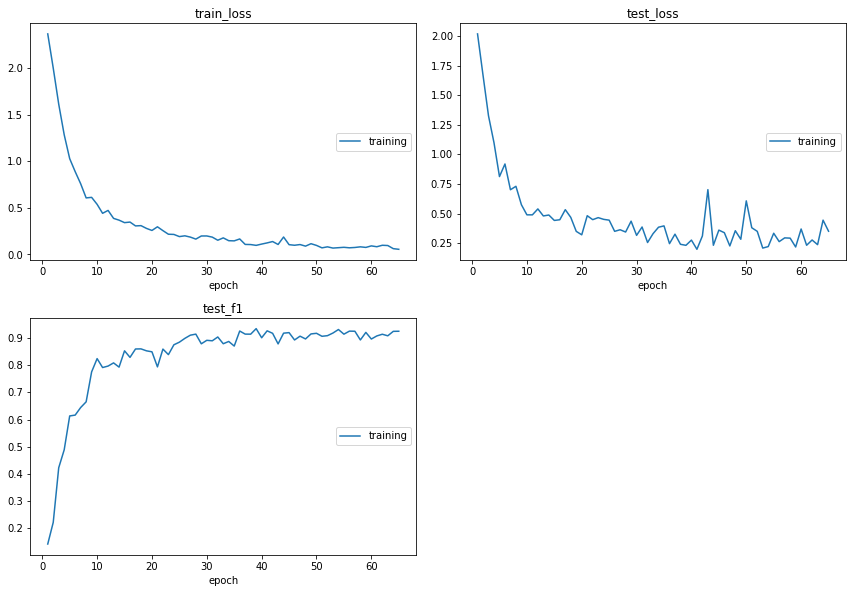

train_loss:
training   (min:    0.055, max:    2.365, cur:    0.055)

test_loss:
training   (min:    0.199, max:    2.017, cur:    0.351)

test_f1:
training   (min:    0.142, max:    0.935, cur:    0.925)


In [10]:
# training
for epoch in range(65):
    squeezenet.train()  # set model to train mode. not sure what that does, probably some optimisations
    
    train_errors = []  
    test_errors = []
    for batch in (tqdm(train_batches)):
        X, Y = batch
        pred = squeezenet(X.to(device))
        
        optimizer.zero_grad()               # reset the gradients
        error = loss(pred, Y.to(device))    # get loss
        error.backward()                    # propogate loss backwards
        optimizer.step()                    # update params
        
        train_errors.append(error.data.item())
        
    
    squeezenet.eval()  # set model to evaluate mode. not sure what that does exactly
    
    # some code to calculate f1 score for the test set
    predict = lambda x: torch.argmax(x, dim=1).cpu().numpy()
    test_predictions = []
    test_actual = []
    for batch in test_batches:
        x, y = batch
        pred = squeezenet(x.to(device))
        test_predictions.append(predict(pred))
        test_errors.append(loss(pred, y.to(device)).data.item())    # get loss
        test_actual.append(np.array(y))
    
#     train_predictions = []
#     train_actual = []
#     for batch in train_batches:
#         x, y = batch
#         pred = squeezenet(x.to(device))
#         train_predictions.append(predict(pred))
#         train_actual.append(np.array(y))

    # log data to be plotted later
    live_losses.update({
        'train_loss': np.mean(np.array(train_errors)),
        'test_loss': np.mean(np.array(test_errors)),
#         'train_f1': f1_score(np.concatenate(train_actual), np.concatenate(train_predictions), average='weighted'),
        'test_f1': f1_score(np.concatenate(test_actual), np.concatenate(test_predictions), average='weighted'),
    })
    live_losses.draw() # plot loss curves   



In [11]:
print(classification_report(
    np.concatenate(test_actual),
    np.concatenate(test_predictions),
    labels = range(len(label_names)),
    target_names = label_names
))

                                             precision    recall  f1-score   support

           FEIT_40W_T8_TUBE_MCRWV_BULB_120V       0.98      0.89      0.93        53
GE - 48 Inch - F40 - T12 - Bulb Fluorescent       0.92      0.92      0.92        12
                            GE_40W_RelaxLED       1.00      0.95      0.97        19
             GE_60W_LED_A19_FROST_5000K_8CT       0.83      1.00      0.91        20
            GE_Appliance_LED_11W_Soft_White       1.00      1.00      1.00         2
            GE_Appliance_LED_40W_Warm_White       0.96      0.88      0.92        25
                GE_Basic_LED_60W_Soft_Light       0.95      0.91      0.93        23
                  GE_Basic_LED_90W_Daylight       0.88      0.94      0.91        32
              GE_Classic_LED_65W_Soft_White       0.90      0.86      0.88        22
              GE_Vintage_LED_60W_Warm_Light       0.96      1.00      0.98        25
            OSI_60W_13W_CFL_SOFT_WHITE_6_CT       0.88      0.93